In [1]:
import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import PIL.Image as Image
import IPython.display as display
%matplotlib inline

from tensorflow.keras import layers

In [2]:
classifier_url ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2" #@param {type:"string"}
IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_url, input_shape=IMAGE_SHAPE+(3,))
])

In [3]:
def load_image( infilename ) :
    img = Image.open( infilename )
    img.load()
    data = np.asarray( img, dtype="int32" )
    return data

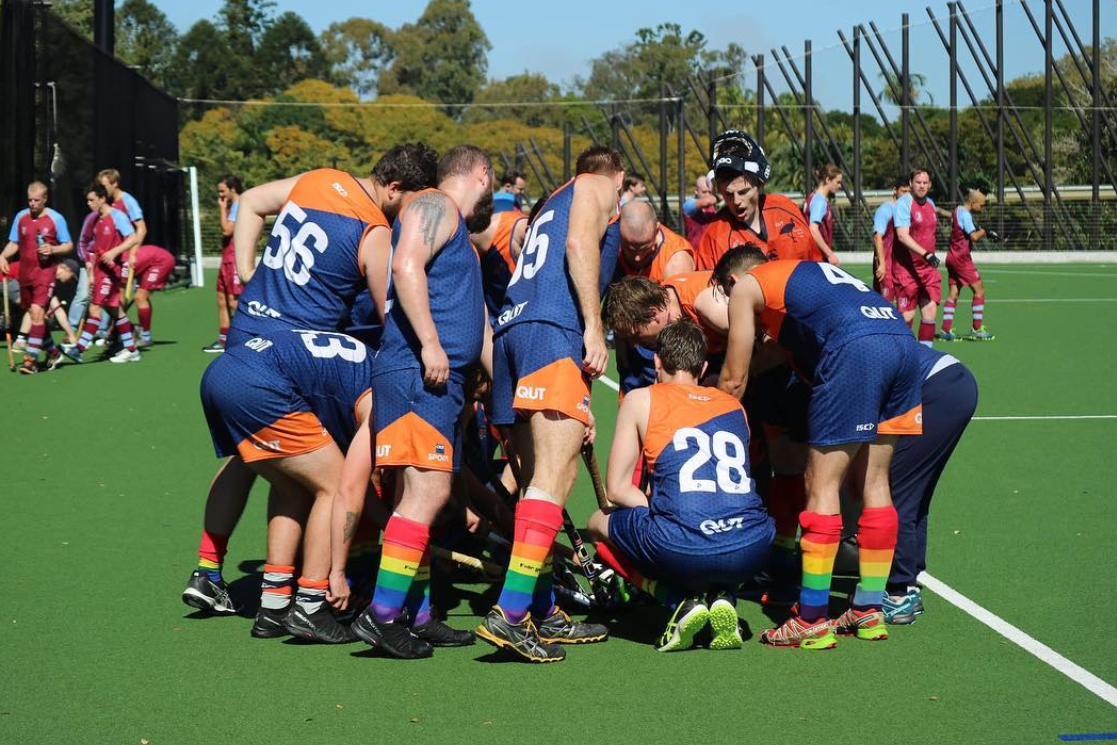

In [4]:
path = 'C:/Users/J/Dropbox/qut team.png'
grace_hopper = Image.open(path).resize(IMAGE_SHAPE)
grace_hopper.resize(IMAGE_SHAPE)
display.display(display.Image(path))

In [5]:
grace_hopper = np.array(grace_hopper)/255.0
grace_hopper.shape

(224, 224, 3)

In [6]:
result = classifier.predict(grace_hopper[np.newaxis, ...])
result.shape

(1, 1001)

In [7]:
predicted_class = np.argmax(result[0], axis=-1)
predicted_class

561

In [8]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

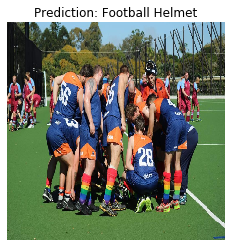

In [9]:
plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())

In [10]:
for i in imagenet_labels[:20]:
    print(i)

background
tench
goldfish
great white shark
tiger shark
hammerhead
electric ray
stingray
cock
hen
ostrich
brambling
goldfinch
house finch
junco
indigo bunting
robin
bulbul
jay
magpie


In [11]:
data_root = tf.keras.utils.get_file(
    'flower_photos','https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',untar=True)

In [12]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
image_data = image_generator.flow_from_directory(str(data_root), target_size=IMAGE_SHAPE)

Found 3670 images belonging to 5 classes.


In [13]:
for image_batch, label_batch in image_data:
    print("Image batch shape: ", image_batch.shape)
    print("Label batch shape: ", label_batch.shape)
    break

Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 5)


In [14]:
result_batch = classifier.predict(image_batch)
result_batch.shape

(32, 1001)

In [15]:
predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
predicted_class_names

array(['daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'head cabbage',
       'daisy', 'vase', 'picket fence', 'greenhouse', 'pot', 'daisy',
       'daisy', 'plastic bag', 'greenhouse', 'hip', 'coral reef', 'bee',
       'coral fungus', 'cardoon', 'spider web', 'daisy', 'vase',
       'stinkhorn', 'daisy', 'artichoke', 'strawberry', 'hip', 'daisy',
       'cardoon', 'daisy', 'confectionery'], dtype='<U30')

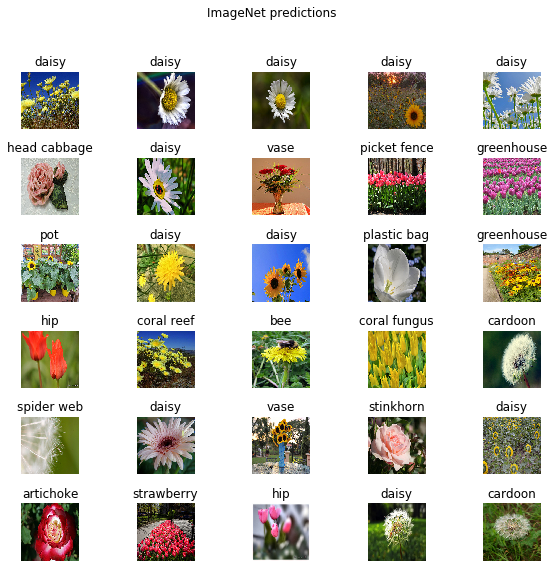

In [16]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
    plt.subplot(6,5,n+1)
    plt.imshow(image_batch[n])
    plt.title(predicted_class_names[n])
    plt.axis('off')
    _ = plt.suptitle("ImageNet predictions")

In [17]:
feature_extractor_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2" #@param {type:"string"}

In [20]:
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=(224,224,3))
feature_extractor_layer.trainable = False

In [19]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(32, 1280)


In [21]:
model = tf.keras.Sequential([
  feature_extractor_layer,
  layers.Dense(image_data.num_classes, activation='softmax')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_2 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [23]:
predictions = model(image_batch)
predictions.shape

TensorShape([32, 5])

In [24]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss='categorical_crossentropy',
  metrics=['acc'])

In [25]:
class CollectBatchStats(tf.keras.callbacks.Callback):
    def __init__(self):
        self.batch_losses = []
        self.batch_acc = []

    def on_train_batch_end(self, batch, logs=None):
        self.batch_losses.append(logs['loss'])
        self.batch_acc.append(logs['acc'])
        self.model.reset_metrics()

In [26]:
steps_per_epoch = np.ceil(image_data.samples/image_data.batch_size)

batch_stats_callback = CollectBatchStats()

history = model.fit(image_data, epochs=2,
                    steps_per_epoch=steps_per_epoch,
                    callbacks = [batch_stats_callback])

W0525 10:36:56.713664  3776 deprecation.py:323] From c:\users\j\documents\github\tutorials\tf_2_tutorials\venv\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/2
 23/115 [=====>........................] - ETA: 6:17 - loss: 1.4152 - acc: 0.6875

KeyboardInterrupt: 

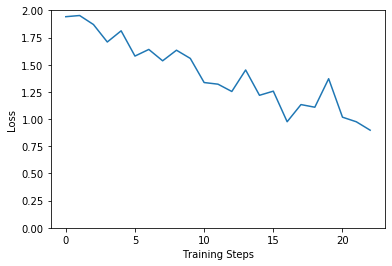

In [27]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats_callback.batch_losses)

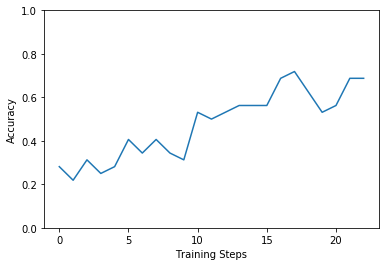

In [28]:
plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_acc)

In [29]:
class_names = sorted(image_data.class_indices.items(), key=lambda pair:pair[1])
class_names = np.array([key.title() for key, value in class_names])
class_names

array(['Daisy', 'Dandelion', 'Roses', 'Sunflowers', 'Tulips'],
      dtype='<U10')

In [30]:
predicted_batch = model.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]

In [31]:
label_id = np.argmax(label_batch, axis=-1)

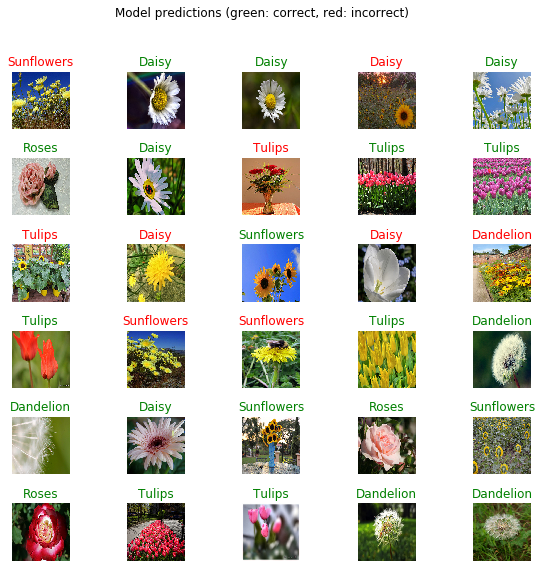

In [32]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
    plt.subplot(6,5,n+1)
    plt.imshow(image_batch[n])
    color = "green" if predicted_id[n] == label_id[n] else "red"
    plt.title(predicted_label_batch[n].title(), color=color)
    plt.axis('off')
    _ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

In [35]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
image_data = image_generator.flow_from_directory("C:/Users/J/.keras/datasets/example", target_size=IMAGE_SHAPE)
class_names = sorted(image_data.class_indices.items(), key=lambda pair:pair[1])
class_names = np.array([key.title() for key, value in class_names])
class_names

Found 2 images belonging to 2 classes.


array(['Me', 'Not Me'], dtype='<U6')

In [36]:
for image_batch, label_batch in image_data:
    print("Image batch shape: ", image_batch.shape)
    print("Label batch shape: ", label_batch.shape)
    break

Image batch shape:  (2, 224, 224, 3)
Label batch shape:  (2, 2)
